In [ ]:
from IPython.display import YouTubeVideo

YouTubeVideo("TEkLFmqi-Bw")


# PyData NYC '23

E-graphs in Python with **`egglog`**

_Saul Shanabrook_


## Aims:

- Faithful bindings for `egglog` rust library.
- "Pythonic" interface, using standard type definitions.
- Usable as base for optimizing/translating expressions for data science libraries in Python


## What is an e-graph?

> E-graphs are these super wonderful data structures for managing equality and equivalence information. They are traditionally **used inside of constraint solvers and automated theorem provers** to implement congruence closure, an efficient algorithm for equational reasoning---but they can also be used to implement **rewrite systems**.
>
> [Talia Ringer - "Proof Automation" course](https://dependenttyp.es/classes/readings/17-egraphs.html)


1. Define types and functions/operators
2. Define rewrite rules
3. Add expressions to graph
4. Run rewrite rules on expressions until saturated (addtional applications have no effect)
5. Extract out lowest cost expression

## Example


In [1]:
from __future__ import annotations
from egglog import *

egraph = EGraph()


@egraph.class_
class NDArray(Expr):
    def __init__(self, i: i64Like) -> None:
        ...

    def __add__(self, other: NDArray) -> NDArray:
        ...

    def __mul__(self, other: NDArray) -> NDArray:
        ...


@egraph.function(cost=2)
def arange(i: i64Like) -> NDArray:
    ...


# Register rewrite rule that asserts for all values x of type NDArray
# x + x = x * 2
x = var("x", NDArray)
egraph.register(rewrite(x + x).to(x * NDArray(2)))


In [2]:
res = arange(10) + arange(10)
egraph.register(res)
egraph.saturate()


In [3]:
egraph.extract(res)


arange(10) * NDArray(2)

## Example with Scikit-learn

Optimize Scikit-learn function with Numba by building an e-graph that implements the Array API.


In [4]:
from sklearn import config_context
from sklearn.datasets import make_classification
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def run_lda(x, y):
    with config_context(array_api_dispatch=True):
        lda = LinearDiscriminantAnalysis()
        return lda.fit(x, y).transform(x)


X_np, y_np = make_classification(random_state=0, n_samples=1000000)
run_lda(X_np, y_np)


array([[ 0.64233002],
       [ 0.63661245],
       [-1.603293  ],
       ...,
       [-1.1506433 ],
       [ 0.71687176],
       [-1.51119579]])

In [5]:
from egglog.exp.array_api import *
from egglog.exp.array_api_jit import jit


@jit
def optimized_fn(X, y):
    # Add metadata about input shapes and dtypes, so that abstract array
    # can pass scikit-learn runtime checks
    assume_dtype(X, X_np.dtype)
    assume_shape(X, X_np.shape)
    assume_isfinite(X)

    assume_dtype(y, y_np.dtype)
    assume_shape(y, y_np.shape)
    assume_value_one_of(y, (0, 1))

    return run_lda(X, y)


Here is an example of a rewrite rule we used to generate Numba compatible code:

```python
rewrite(
    std(x, axis)
).to(
    sqrt(mean(square(x - mean(x, axis, keepdims=TRUE)), axis))
)
```


We can see the optimized expr:


In [6]:
optimized_fn.expr


_NDArray_1 = NDArray.var("X")
assume_dtype(_NDArray_1, DType.float64)
assume_shape(_NDArray_1, TupleInt(Int(1000000)) + TupleInt(Int(20)))
assume_isfinite(_NDArray_1)
_NDArray_2 = NDArray.var("y")
assume_dtype(_NDArray_2, DType.int64)
assume_shape(_NDArray_2, TupleInt(Int(1000000)))
assume_value_one_of(_NDArray_2, TupleValue(Value.int(Int(0))) + TupleValue(Value.int(Int(1))))
_NDArray_3 = astype(
    NDArray.vector(TupleValue(sum(_NDArray_2 == NDArray.scalar(Value.int(Int(0)))).to_value()) + TupleValue(sum(_NDArray_2 == NDArray.scalar(Value.int(Int(1)))).to_value())),
    DType.float64,
) / NDArray.scalar(Value.float(Float(1000000.0)))
_NDArray_4 = zeros(TupleInt(Int(2)) + TupleInt(Int(20)), OptionalDType.some(DType.float64), OptionalDevice.some(_NDArray_1.device))
_MultiAxisIndexKey_1 = MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice()))
_IndexKey_1 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(0))) + _MultiAxisIndexKey_1)
_NDArray_5 = _NDArray_1[ndarray_index(_NDArray_2 == NDArray.scalar(Value.int(Int(0))))]
_OptionalIntOrTuple_1 = OptionalIntOrTuple.some(IntOrTuple.int(Int(0)))
_NDArray_4[_IndexKey_1] = sum(_NDArray_5, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_5.shape[Int(0)]))
_IndexKey_2 = IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.int(Int(1))) + _MultiAxisIndexKey_1)
_NDArray_6 = _NDArray_1[ndarray_index(_NDArray_2 == NDArray.scalar(Value.int(Int(1))))]
_NDArray_4[_IndexKey_2] = sum(_NDArray_6, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_6.shape[Int(0)]))
_NDArray_7 = concat(TupleNDArray(_NDArray_5 - _NDArray_4[_IndexKey_1]) + TupleNDArray(_NDArray_6 - _NDArray_4[_IndexKey_2]), OptionalInt.some(Int(0)))
_NDArray_8 = square(_NDArray_7 - expand_dims(sum(_NDArray_7, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_7.shape[Int(0)]))))
_NDArray_9 = sqrt(sum(_NDArray_8, _OptionalIntOrTuple_1) / NDArray.scalar(Value.int(_NDArray_8.shape[Int(0)])))
_NDArray_10 = copy(_NDArray_9)
_NDArray_10[ndarray_index(_NDArray_9 == NDArray.scalar(Value.int(Int(0))))] = NDArray.scalar(Value.float(Float(1.0)))
_TupleNDArray_1 = svd(sqrt(NDArray.scalar(Value.float(Float.rational(Rational(1, 999998))))) * (_NDArray_7 / _NDArray_10), FALSE)
_Slice_1 = Slice(OptionalInt.none, OptionalInt.some(sum(astype(_TupleNDArray_1[Int(1)] > NDArray.scalar(Value.float(Float(0.0001))), DType.int32)).to_value().to_int))
_NDArray_11 = (_TupleNDArray_1[Int(2)][IndexKey.multi_axis(MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(_Slice_1)) + _MultiAxisIndexKey_1)] / _NDArray_10).T / _TupleNDArray_1[
    Int(1)
][IndexKey.slice(_Slice_1)]
_TupleNDArray_2 = svd(
    (sqrt((NDArray.scalar(Value.int(Int(1000000))) * _NDArray_3) * NDArray.scalar(Value.float(Float(1.0)))) * (_NDArray_4 - (_NDArray_3 @ _NDArray_4)).T).T @ _NDArray_11, FALSE
)
(
    (_NDArray_1 - (_NDArray_3 @ _NDArray_4))
    @ (
        _NDArray_11
        @ _TupleNDArray_2[Int(2)].T[
            IndexKey.multi_axis(
                _MultiAxisIndexKey_1
                + MultiAxisIndexKey(
                    MultiAxisIndexKeyItem.slice(
                        Slice(
                            OptionalInt.none,
                            OptionalInt.some(
                                sum(astype(_TupleNDArray_2[Int(1)] > (NDArray.scalar(Value.float(Float(0.0001))) * _TupleNDArray_2[Int(1)][IndexKey.int(Int(0))]), DType.int32))
                                .to_value()
                                .to_int
                            ),
                        )
                    )
                )
            )
        ]
    )
)[IndexKey.multi_axis(_MultiAxisIndexKey_1 + MultiAxisIndexKey(MultiAxisIndexKeyItem.slice(Slice(OptionalInt.none, OptionalInt.some(Int(1))))))]

And the generated code:


In [7]:
import inspect

print(inspect.getsource(optimized_fn))


def __fn(X, y):
    assert X.dtype == np.dtype(np.float64)
    assert X.shape == (1000000, 20,)
    assert np.all(np.isfinite(X))
    assert y.dtype == np.dtype(np.int64)
    assert y.shape == (1000000,)
    assert set(np.unique(y)) == set((0, 1,))
    _0 = y == np.array(0)
    _1 = np.sum(_0)
    _2 = y == np.array(1)
    _3 = np.sum(_2)
    _4 = np.array((_1, _3,)).astype(np.dtype(np.float64))
    _5 = _4 / np.array(1000000.0)
    _6 = np.zeros((2, 20,), dtype=np.dtype(np.float64))
    _7 = np.sum(X[_0], axis=0)
    _8 = _7 / np.array(X[_0].shape[0])
    _6[0, :] = _8
    _9 = np.sum(X[_2], axis=0)
    _10 = _9 / np.array(X[_2].shape[0])
    _6[1, :] = _10
    _11 = _5 @ _6
    _12 = X - _11
    _13 = np.sqrt(np.array(float(1 / 999998)))
    _14 = X[_0] - _6[0, :]
    _15 = X[_2] - _6[1, :]
    _16 = np.concatenate((_14, _15,), axis=0)
    _17 = np.sum(_16, axis=0)
    _18 = _17 / np.array(_16.shape[0])
    _19 = np.expand_dims(_18, 0)
    _20 = _16 - _19
    _21 = np.square(_20)
   

As well as the e-graph:


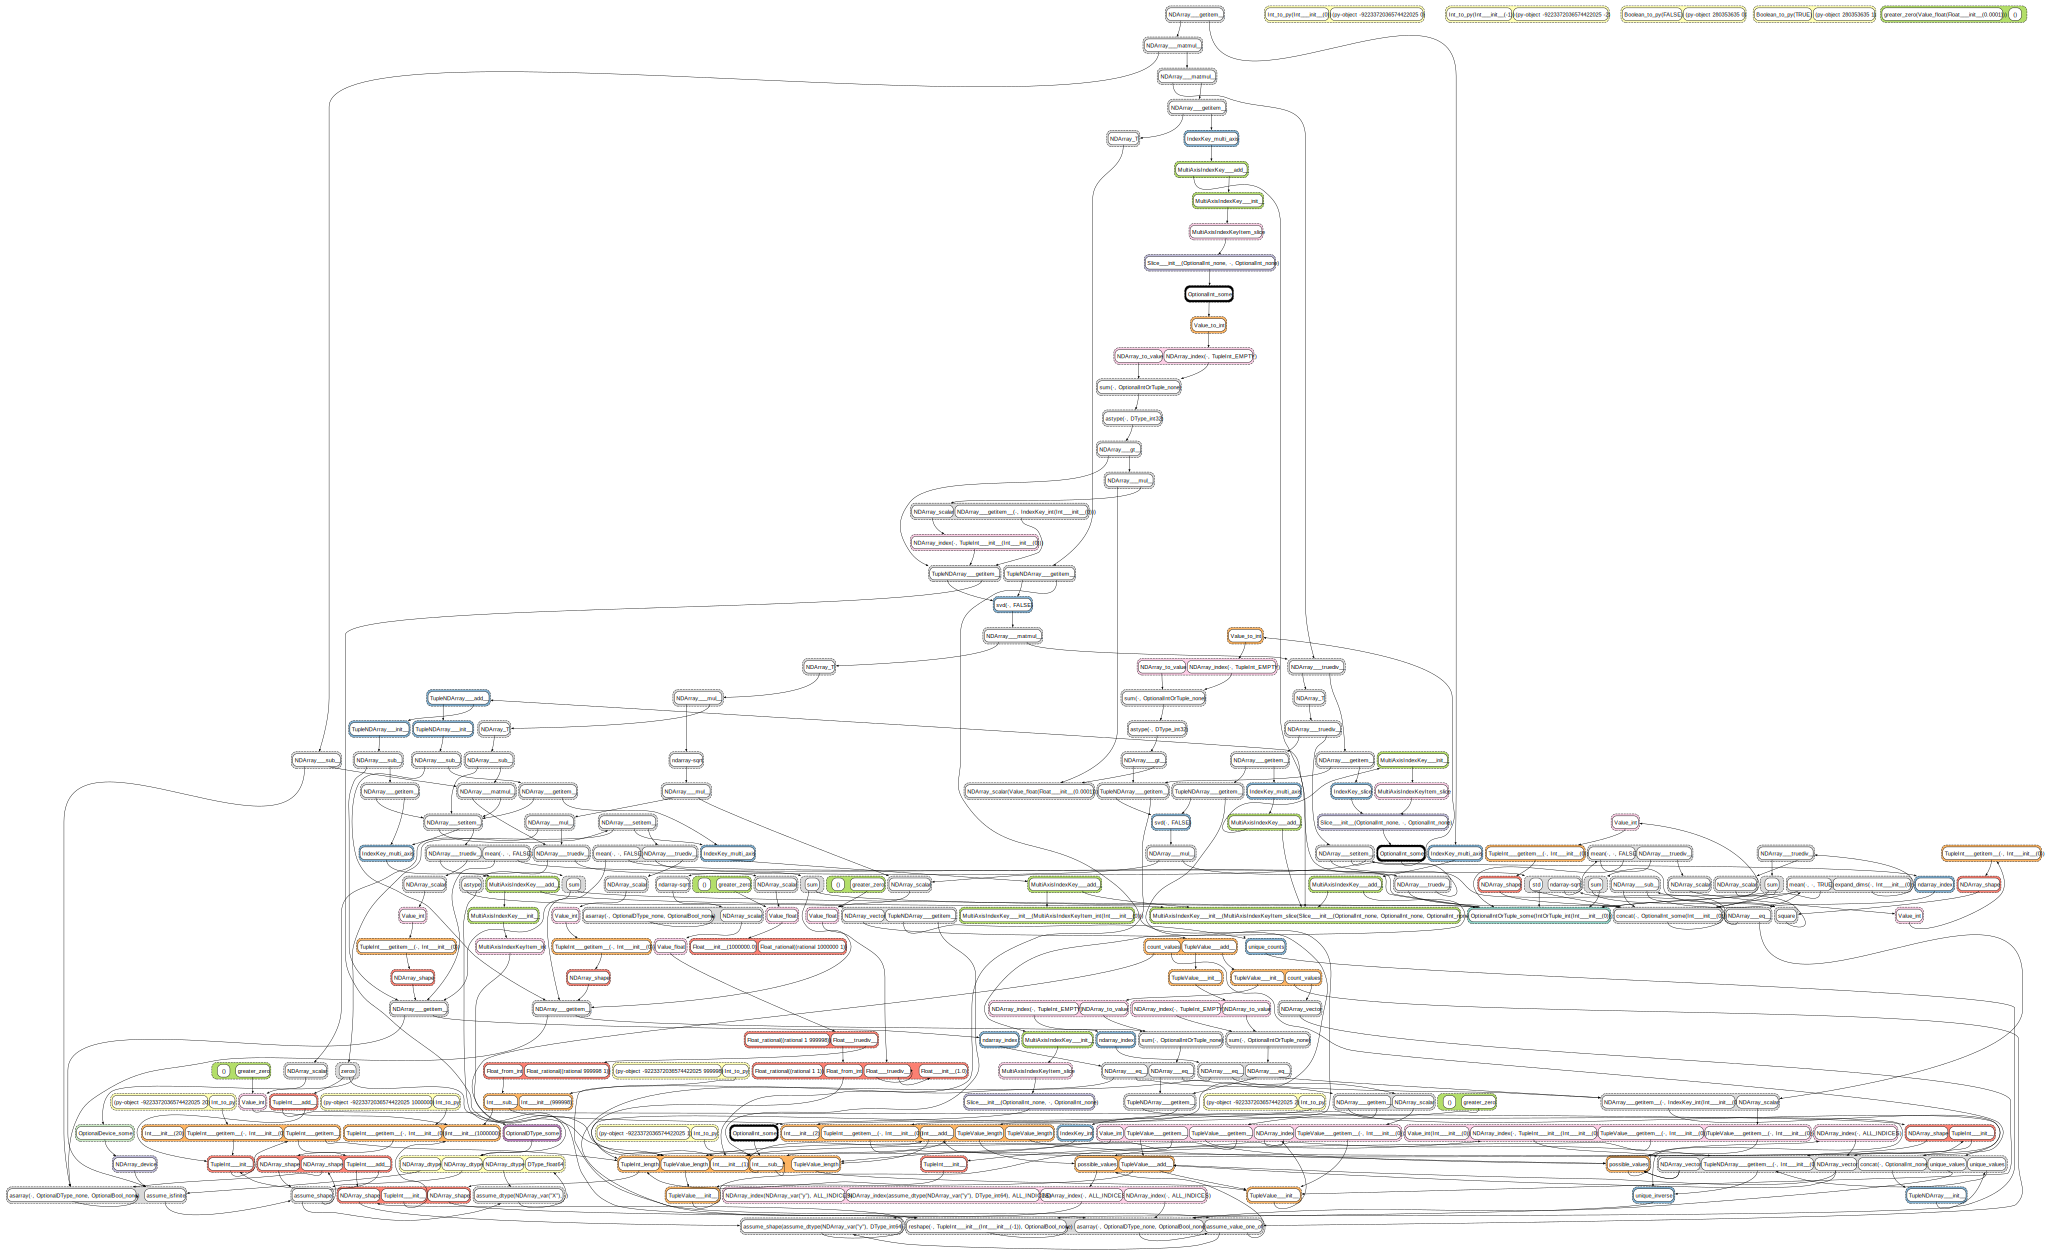

In [8]:
optimized_fn.egraph


In [9]:
import numba
import numpy as np

numba_fn = numba.njit(fastmath=True)(optimized_fn)
assert np.allclose(run_lda(X_np, y_np), numba_fn(X_np, y_np))


/var/folders/xn/05ktz3056kqd9n8frgd6236h0000gn/T/egglog-82012193-cafe-439c-94d4-48ec846ca9e6.py:56: NumbaPerformanceWarning: '@' is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  _45 = _33 @ _40[2].T[:, :_44]


In [10]:
import timeit
import pandas as pd

stmts = {
    "original": "run_lda(X_np, y_np)",
    "numba": "numba_fn(X_np, y_np)",
}
df = pd.DataFrame.from_dict(
    {
        name: timeit.repeat(stmt, globals=globals(), number=1, repeat=10)
        for name, stmt in stmts.items()
    }
)


# ~30% speedup

_on my machine, not a scientific benchmark_


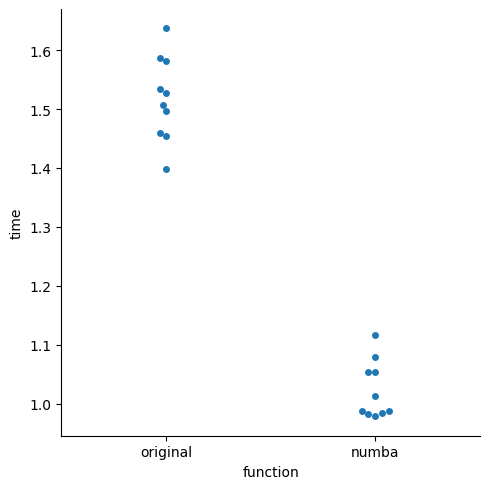

In [11]:
import seaborn as sns

df_melt = pd.melt(df, var_name="function", value_name="time")
_ = sns.catplot(data=df_melt, x="function", y="time", kind="swarm")


## Conclusions

- `egglog` is a Python interface to e-graphs, which respects the underlying semantics but provides a Python interface.
- Flexible enough to represent Array API and translate this back to Python source
- If you have a Python library which optimizes/translates expressions, try it out!
- Goals

  - support the ecosystem in collaborating better between libraries, to encourage experimentation and innovation
  - dont reimplement the world: build on academic programming language research

- `pip install egglog`
- https://github.com/metadsl/egglog-python
- Say hello: https://egraphs.zulipchat.com/
